# Pairs Trading Strategy

A pairs trading strategy is a non-directional, mean reverting trading strategy that involves utilising statistical and technical analysis to generate alpha. 

It matches a long position and a short position across a pair of equity securities that share an underlying economic link and are highly correlated. The positions are opened when the pair is trading at a price relationship out of their historical trading range and closed when they revert back to equilibrium. This price relationship is usually modelled via the price spread/ratio.

In Pairs Trading, one asset's long will always be hedged against another's short and vice versa. Thus it falls under the mean reversion or statistical arbitrage umbrella of quantitative trading strategies as it has a distinct advantage of always being hedge against market movements.

#### Assumptions
Two correlated assets will drift in and out of equilibrium (based on spread/ratio) which provides opportunities to capitalise on statistical arbitrage where we:

- Long the undervalued security
- Short the overvalued security

#### Goals
1. Modelling the economic link between asset pairs to identifying a tradable asset pair that has a clearly identified equilibrium based on statistical analysis
2. Building a model that produces trading signals for our strategy that capitalises on assets trading out of equilibrium 


## Goal 1: Identifying Tradable Asset Pairs

### Acquiring Data

First we have to get historical pricing data. We create a function that returns adjusted close as our primary data in a pandas DataFrame. We'll be using historical data from 2 years prior.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

/Users/Riley/Library/Python/3.9/lib/python/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Get historical pricing data
def getHistoricalData(tickers, start, end):
    """ This function returns a pd Dataframe with all adj closing information of tickers passed"""
    s_year, s_month, s_day = start
    e_year, e_month, e_day = end
    # Getting data from Yahoo Finance
    df = yf.download(tickers, datetime(s_year, s_month, s_day), datetime(e_year, e_month, e_day), group_by='tickers')
    # Grabbing the adj close data
    df = df.iloc[:, df.columns.get_level_values(1)=='Adj Close']
    df.columns = df.columns.droplevel(1)
    
    return df

### Correlation
Correlation refers to the extent to which two random varaibles are linearly related and can be used to find a suitable pair to trade. While it's easy to implement and interpret, it does not provide a statistically strong condition (we will see why in a bit, and use a stronger condition) when used on it's own.

$$ Corr(X,Y), \rho = \frac{Cov(X,Y)}{\sigma_X\sigma_Y} $$

Qualitatively, companies from the same sector would be more than likely to produce price movements that are very similar. 

In this project, we will be using a basket of 10 equities belonging to finance companies in the S&P500 index to sieve out a pair that is highly correlated in hopes of determining an asset pair that provides mean reverting opportunities.

In [3]:
tickers = ['BK', 'BAC', 'WFC', 'C', 'CFG', 'GS', 'MS', 'TFC', 'JPM', 'SCHW']
start = [2020,1,1]
end = [2022,1,1]

prices = getHistoricalData(tickers, start, end)
print(prices.shape)
prices.tail() # to show most recent data

[*********************100%***********************]  10 of 10 completed
(506, 10)


,GS,TFC,BK,BAC,MS,WFC,C,SCHW,CFG,JPM
Date,,,,,,,,,,
2021-12-27,375.377716,55.592667,55.794250,43.343128,95.385010,46.981506,57.110584,84.608490,44.301292,151.011368
2021-12-28,374.961731,55.820904,55.737038,43.401390,94.976494,46.644341,57.082333,84.292999,44.395149,151.469681
2021-12-29,373.597778,55.896976,55.651226,43.333424,93.798431,46.673241,57.007004,83.760628,44.395149,151.393295
2021-12-30,372.939941,55.630711,55.269859,43.236324,93.864937,46.336071,56.903427,83.287415,44.366989,151.316910
2021-12-31,370.066833,55.678257,55.374741,43.197487,93.256905,46.220474,56.865753,82.912766,44.348225,151.192795


In [4]:
# Correlation Matrix
corr_matrix = prices.corr()
corr_matrix

,GS,TFC,BK,BAC,MS,WFC,C,SCHW,CFG,JPM
GS,1.000000,0.919023,0.946170,0.966947,0.991522,0.842445,0.795330,0.980013,0.948555,0.966236
TFC,0.919023,1.000000,0.925322,0.960068,0.900163,0.872719,0.896251,0.936508,0.986976,0.979157
BK,0.946170,0.925322,1.000000,0.979189,0.929386,0.920808,0.820189,0.952721,0.931296,0.948094
BAC,0.966947,0.960068,0.979189,1.000000,0.945820,0.917290,0.855751,0.976238,0.971718,0.982982
MS,0.991522,0.900163,0.929386,0.945820,1.000000,0.795533,0.752516,0.971031,0.932333,0.946966
WFC,0.842445,0.872719,0.920808,0.917290,0.795533,1.000000,0.887361,0.851796,0.868306,0.900209
C,0.795330,0.896251,0.820189,0.855751,0.752516,0.887361,1.000000,0.781994,0.887356,0.893760
SCHW,0.980013,0.936508,0.952721,0.976238,0.971031,0.851796,0.781994,1.000000,0.962274,0.971439
CFG,0.948555,0.986976,0.931296,0.971718,0.932333,0.868306,0.887356,0.962274,1.000000,0.989179
JPM,0.966236,0.979157,0.948094,0.982982,0.946966,0.900209,0.893760,0.971439,0.989179,1.000000


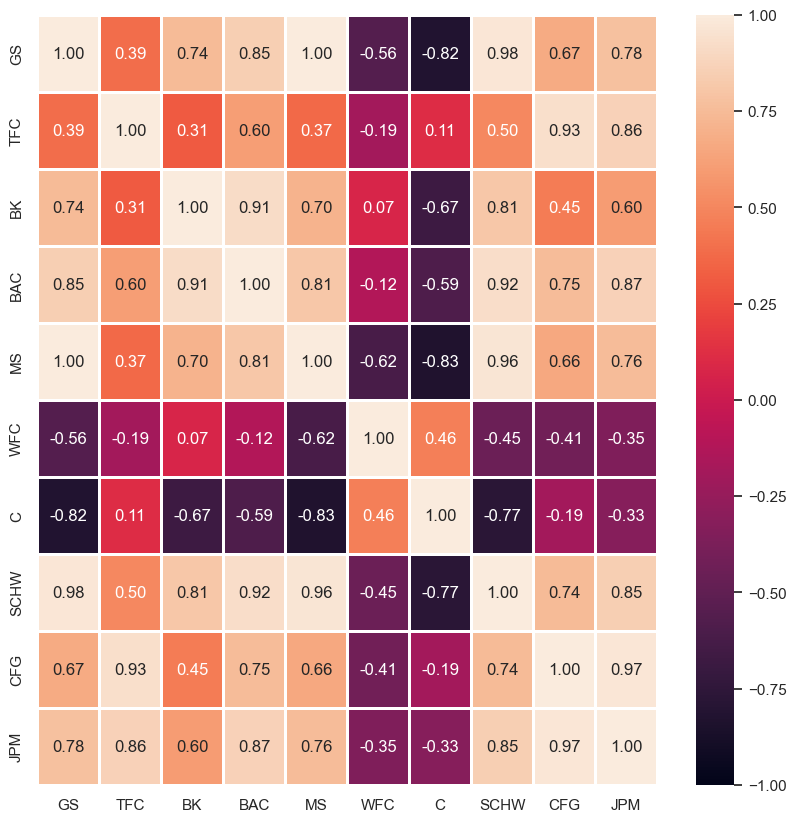

In [5]:
# Printing correlation matrix out as a heatmap
plt.figure(figsize=(10,10))
sb.heatmap(corr_matrix.corr(), vmin = -1, vmax = 1, linewidths = 1, annot = True, fmt='.2f');

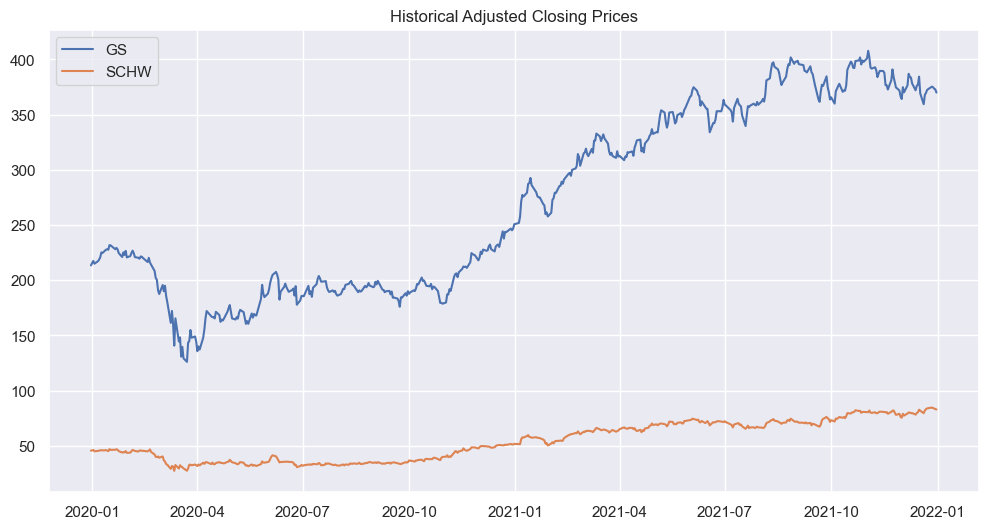

In [6]:
# High Correlation between GS and SCHW of ~ 0.98
plt.figure(figsize=(12, 6))
GS = prices['GS']
SCHW = prices['SCHW']
plt.plot(GS, label = 'GS')
plt.plot(SCHW, label = 'SCHW')
plt.title('Historical Adjusted Closing Prices')
plt.legend()
plt.show();

### Spread

Now that we have our two assets, we need to discern if they're a tradable assset pair. We model their price relationship via the spread. Price ratio can be used as well but for this notebook, the spread would be used.

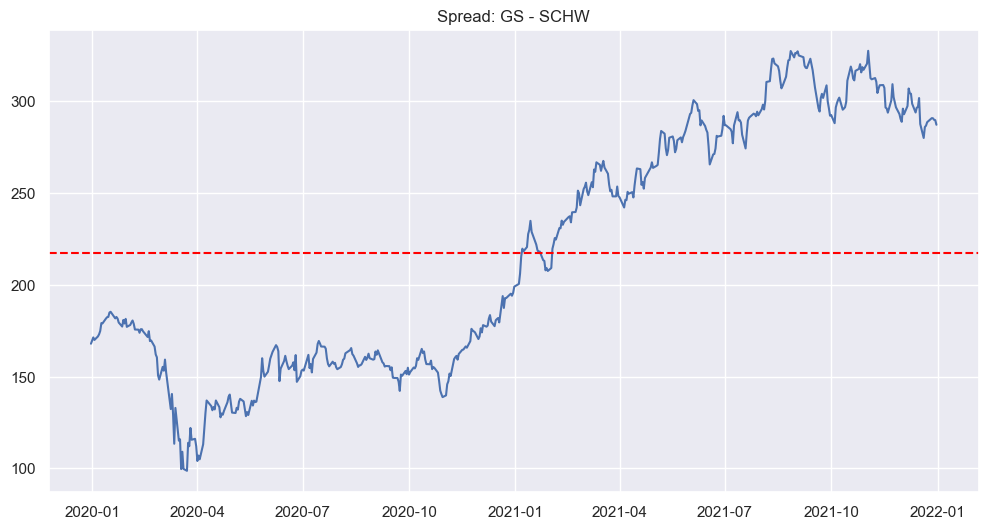

In [7]:
# plot the spread
plt.figure(figsize=(12, 6))
spread = GS-SCHW
spread.name = 'GS-SCHW'
plt.plot(spread)

# Add the mean
plt.axhline(spread.mean(), color='red', linestyle='--') 
plt.title("Spread: GS - SCHW")
plt.show();

### Stationarity and Cointegration

Referring back to our main assumption, the idea is to try and establish a stationary relationship that can be traded within the pair. With a stationary spread, we can go long (in the above spread - long GS, short SCHW) when the spread is small and go short (short GS, long SCHW) when the the spread is large as we will have high confidence that they are mean reverting.

#### Stationarity
A time series is defined as sationary in mathematics and statistics when the parameters of the data generating process do not change over time. This means that it's mean and standard deviation remain constant. If the mean of a spread is dynamic, the mean reversion pairs trading strategy will fail as descriptive statistics would be meaningless.

#### Cointegration
Intuitively, cointegration tests are used to establish correlation between the time series in the long term and proves to be a more robust condition to understand if two time series behave similarly to one another.

Cointegration is defined as follows: For some set of time series ($X_1$, $X_2$, $\dots$, $X_k$), if all series are $I(1)$, and some linear combination of them is $I(0)$, we say the set of time series is cointegrated. In other wards, if a linear combination of non-stationary variables produces a stationary series, then they are cointegrated.

#### Testing for stationarity
To test for a stationary spread, we can conduct cointegration tests like the `Engle-Granger` for a multi-variate time series or the `Augmented Dickey Fuller` test for a uni-variate time series.

#### GS-SCHW Spread
The spread between GS-SCHW looks like it's following a increasing trend and does not look stationary. If we trade on this time series, we will get garbage signals. 

The computed mean shows the mean of all data points at a certain snapshot in time. Thus, it is meaningless to use this mean to forecast future price movements if its dynamic. Thus, we require the spread to be stationary to do apply meaningful mean reversion strategy.

#### Engle Grager Test

In [8]:
def engleGrangerTest(S1, S2, cutoff=0.05):
    """This function discerns if 2 variables are cointegrated by the Engle Granger Test"""
    result = coint(S1, S2)
    score, pvalue, _ = result
    
    if pvalue < cutoff:
        print(f'p-value = {pvalue}. \n{S1.name} and {S2.name} are likely cointegrated. Hence, there likely exists a linear combination of the 2 series that are stationary.')
    else:
        print(f'p-value = {pvalue}. \n{S1.name} and {S2.name} are likely not cointegrated. Hence, there likely does not exists a linear combination of the 2 series that are stationary.')

engleGrangerTest(GS, SCHW)

p-value = 0.26575752088203636. 
GS and SCHW are likely not cointegrated. Hence, there likely does not exists a linear combination of the 2 series that are stationary.


#### Augemented Dickey Fuller Test

In [9]:
def adf(S, cutoff=0.05):
    """This function discerns if a series is stationary of non-stationary by ADF"""
    pvalue = adfuller(S)[1]

    if pvalue < cutoff:
        print(f'p-value = {pvalue}.\n{S.name} is likely stationary.')
    else:
        print(f'p-value = {pvalue}.\n{S.name} is likely non-stationary.')

adf(spread)

p-value = 0.8891889499997031.
GS-SCHW is likely non-stationary.


Since the spread between GS and SCHW are not cointegrated and non-stationary by both our tests, we cannot implement a pairs trading strategy on said pair and need to look for another applicable pair to trade on.

### Multiple Comparisons Bias
The reason for selecting only 10 bank stocks to find cointegrated pairs is to avoid falling prey to the multiple comparisons bias. The multiple comparisons bias is the increased chance to incorrectly generate a significant p-value when many tests are run. By reducing the number of pairs we are testing on, it results in less exposure to the bias as opposed to if we tested on a basket of 100 stocks.

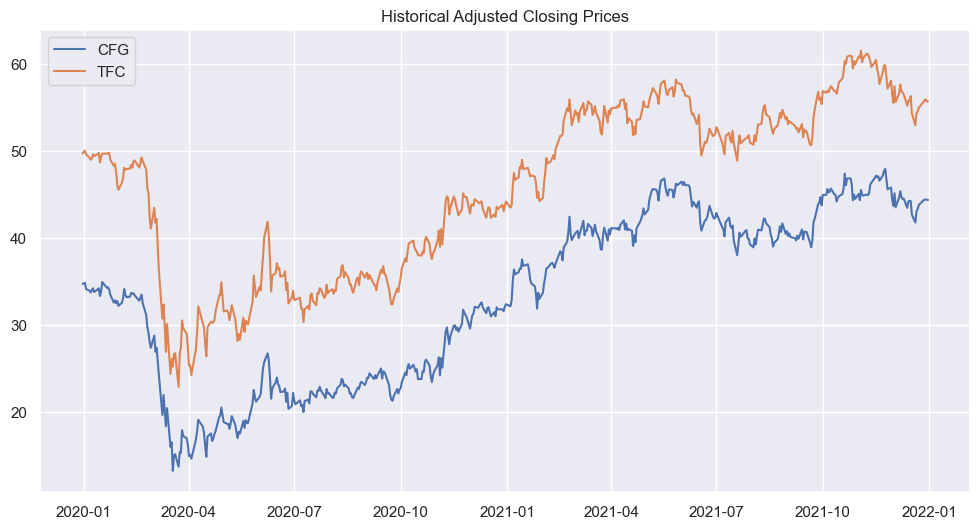

In [10]:
# High correlation between CFG and TFC of ~ 0.93
plt.figure(figsize=(12, 6))
CFG = prices['CFG']
TFC = prices['TFC']
plt.plot(CFG, label = 'CFG')
plt.plot(TFC, label = 'TFC')
plt.title('Historical Adjusted Closing Prices')
plt.legend()
plt.show();

Now to show cointegration, we'll need to find some linear combination of CFG and TFC that is stationary. Graphically, we can take the spread, TFC - CFG, that we also defined earlier will model price relationship between our asset pair to check for stationarity.

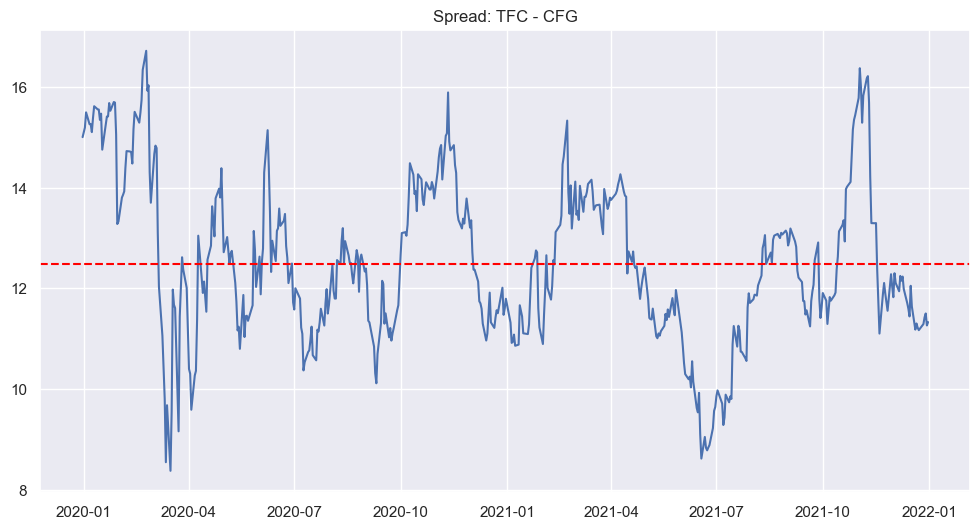

In [11]:
# plot the spread
plt.figure(figsize=(12, 6))
spread = TFC - CFG
spread.name = 'TFC-CFG'
plt.plot(spread)

# Add the mean
plt.axhline(spread.mean(), color='red', linestyle='--') 
plt.title("Spread: TFC - CFG")
plt.show();

Similarly, we conduct our cointegration tests to check for stationarity on the TFC-CFG spread.

In [12]:
engleGrangerTest(TFC, CFG)

p-value = 0.013796789669244814. 
TFC and CFG are likely cointegrated. Hence, there likely exists a linear combination of the 2 series that are stationary.


In [13]:
adf(spread)

p-value = 0.0029529379332930974.
TFC-CFG is likely stationary.


An interesting point to note is that the time series of `TFC` and `CFG` are clearly non-stationary but when combined, form a stationary time series. This therefore implies they are cointegrated which is used to describe two or more non-stationary time series that can be linearly combined to form a stationary one. 

The statistical tests above signifies stationarity in the spread between `TFC` and `CFG`. We can confidently say that if the spread goes above or below a certain value, we can expect it to revert back to its mean. This presents a statistical arbitrage opportunity for us to capitalize on.

## Goal 2: Building Model Based on Statistical Analysis

Now that we have defined a pair of assets (TFC, CFG) whose spread is stationary by our cointegration tests defined above. However the absolute spread is not very useful in statistical terms. We thus normalize our spread by using z-scores (no. of standard deviations a datapoint is from the mean) to generate trading signals for our trading strategy - specfically trading signals of when to long/short the spread.

$$\mathcal{z}_{i}=\frac{x_{i}-\bar{x}}{s} $$

In [14]:
def zscore(S):
    '''This function returns the Z-scores of a series'''
    return (S - S.mean()) / np.std(S)

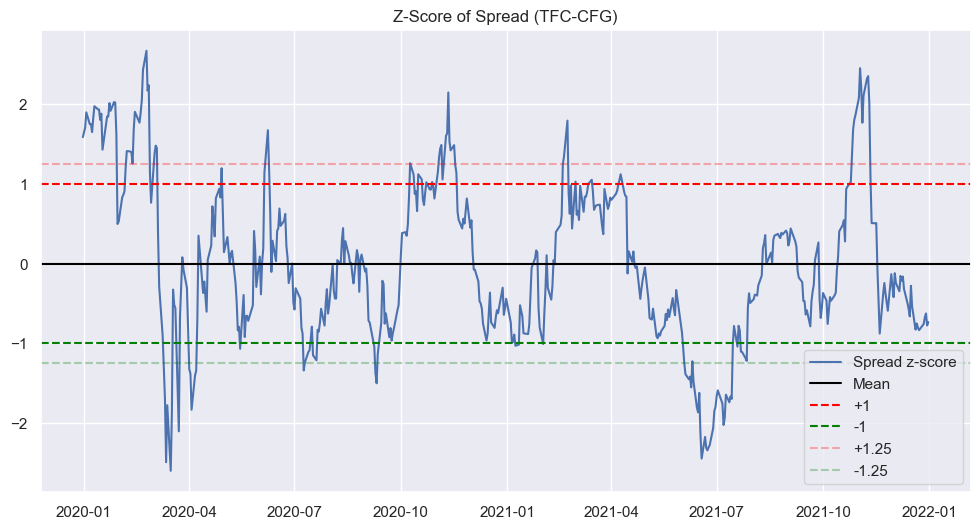

In [15]:
plt.figure(figsize=(12,6))

plt.plot(zscore(spread))
plt.axhline((zscore(spread)).mean(), color = 'black')

# Setting the upper and lower bounds to be the z score of 1 and -1 where 68% of our data will lie between
plt.axhline(1.0, color='red', linestyle='--') 
plt.axhline(-1.0, color='green', linestyle='--') 

# 95% of our data will lie between these bounds
plt.axhline(1.25, color='red', alpha=0.3, linestyle='--') 
plt.axhline(-1.25, color='green',alpha=0.3, linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1', '+1.25', '-1.25'])
plt.title('Z-Score of Spread (TFC-CFG)')
plt.show();

By setting 4 other lines placed at the z-score of 1 and -1, 1.25, -1.25, we can clearly see that for the most part, any big divergences from the mean eventually converges back. This helps us determine when and what bets to place.

1. Long the spread (long TFC, short CFG) when it falls below the green lines.
2. Short the spread (short TFC, long CFG) when it falls below the green lines.

### Look Ahead Bias

Look ahead bias occurs by using information or data that would not have been known or available during the period being analyzed. In the graph above, the Z-scores were a function of the mean and standard deviation of the entire time series. 

If we wanted to make a prediction in April 2020 for example, we would effectively be using data from the entire time series, which would not have been available during said point in time. Thus, to prevent look ahead bias, we need to trade using constantly updating statistics. In this case, we make use of moving averages which is simply an average of the last $n$ datapoints for each given time. It will thus be undefined for the first $n$ datapoints in our series. Shorter MAs will be less reliable but respond quicker while longer MAs will be smoother but take more time to incorporate new information.

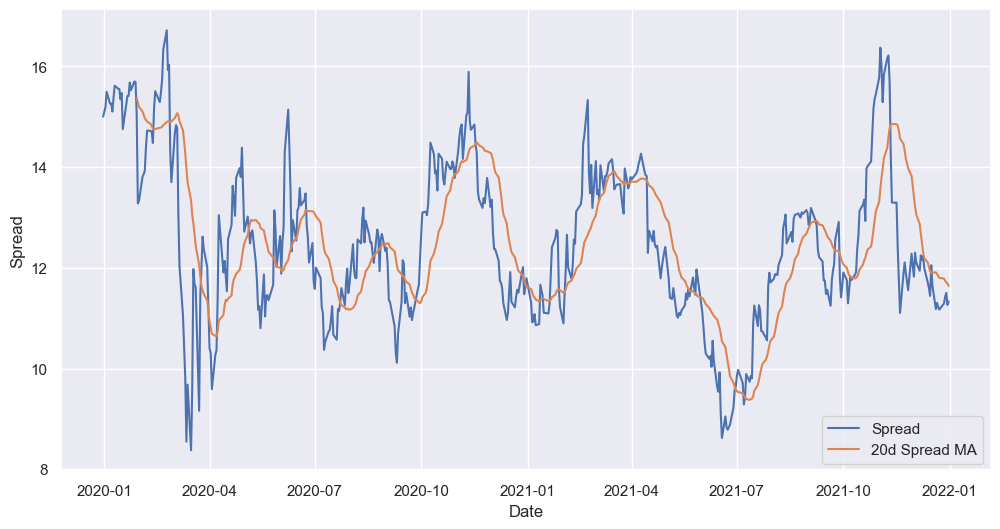

In [16]:
plt.figure(figsize=(12, 6))

# getting 20d moving averages of price spread
spreads_mavg20 = spread.rolling(window=20, center=False).mean()

# plotting them
plt.plot(spread.index, spread.values)
plt.plot(spreads_mavg20.index, spreads_mavg20.values)
plt.legend(['Spread', '20d Spread MA'])
plt.xlabel('Date')
plt.ylabel('Spread')
plt.show()

Using moving averages above, we can compute the Z-score of the spread at each given time, resulting in a rolling z-score based on the rolloing period. This will tell us how extreme the spread is and when to enter a trade.

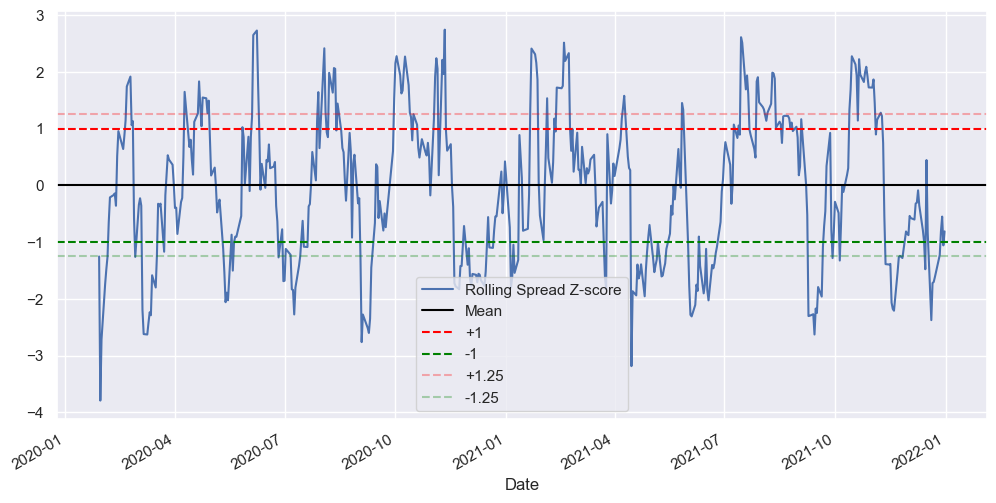

In [17]:
# Taking a rolling 20d standard deviation
std_20 = spread.rolling(window=20, center=False).std()
# Computing z-score for each day based on a 20 day rolling window
zscore_20 = (spread - spreads_mavg20)/std_20

# plotting them
plt.figure(figsize=(12, 6))
zscore_20.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(1.25, color='red', alpha=0.3, linestyle='--')
plt.axhline(-1.25, color='green', alpha=0.3, linestyle='--')
plt.legend(['Rolling Spread Z-score', 'Mean', '+1','-1','+1.25', '-1.25'])
plt.show()

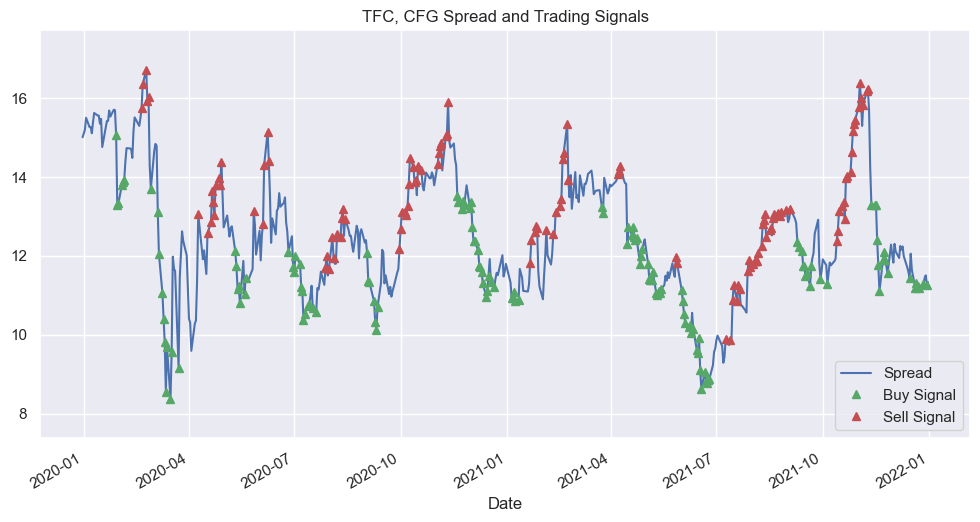

In [18]:
plt.figure(figsize=(12, 6))
spread.plot()

buy = spread.copy()
sell = spread.copy()

# Long the spread when the z-score <= -1 as we expect spread to increase
# Hence z-score > 1 set to 0
buy[zscore_20>-1] = 0 
# Same idea for shorting
sell[zscore_20<1] = 0 

# zscore nan values
buy[zscore_20.isna()] = 0
sell[zscore_20.isna()] = 0

# plotting the signals on the spread
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, spread.min()-1, spread.max()+1))
plt.legend(['Spread', 'Buy Signal', 'Sell Signal'])
plt.title('TFC, CFG Spread and Trading Signals')
plt.show()

-------------------------------------------------------------------------------------------------------------
## Improvements

### 1. All Cointegrated Pairs

Producing cointegration heatmap on all pairs that are cointegrated from basket of selection. Include SPY in the basket to avoid <b>confounding variables bias</b>.

In [19]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    pairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            S1 = data.iloc[:, i]
            S2 = data.iloc[:, j]
            result = coint(S1, S2)
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            
            if pvalue < 0.05:
                pairs.append((data.keys()[i], data.keys()[j]))
                
    return pvalue_matrix, pairs

In [20]:
spy_df = yf.download('SPY', datetime(2020, 1, 1), datetime(2022, 1, 1))
spy_df = spy_df['Adj Close']
all_df = pd.concat([prices, spy_df], axis=1)
all_df.columns = list(prices.keys()) + ['SPY']
all_df

[*********************100%***********************]  1 of 1 completed


,GS,TFC,BK,BAC,MS,WFC,C,SCHW,CFG,JPM,SPY
Date,,,,,,,,,,,
2019-12-31,213.448898,49.707664,45.236774,32.674606,46.050106,49.154133,70.167213,45.564011,34.703484,125.288887,305.658966
2020-01-02,217.524246,50.016575,45.767059,33.064251,46.878864,49.108463,71.344131,46.205894,34.823120,126.807823,308.517456
2020-01-03,214.980637,49.601753,45.182846,32.377728,46.122173,48.806946,70.000336,45.037094,34.105297,125.134422,306.181244
2020-01-06,217.180771,49.186928,45.605282,32.331345,45.960022,48.514587,69.780762,45.353241,33.925842,125.034943,307.349365
2020-01-07,218.610413,48.975113,46.063667,32.117966,45.869946,48.112587,69.174728,45.621498,33.712212,122.909233,306.485107
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,375.377716,55.592667,55.794250,43.343128,95.385010,46.981506,57.110584,84.608490,44.301292,151.011368,467.855286
2021-12-28,374.961731,55.820904,55.737038,43.401390,94.976494,46.644341,57.082333,84.292999,44.395149,151.469681,467.472961
2021-12-29,373.597778,55.896976,55.651226,43.333424,93.798431,46.673241,57.007004,83.760628,44.395149,151.393295,468.070953


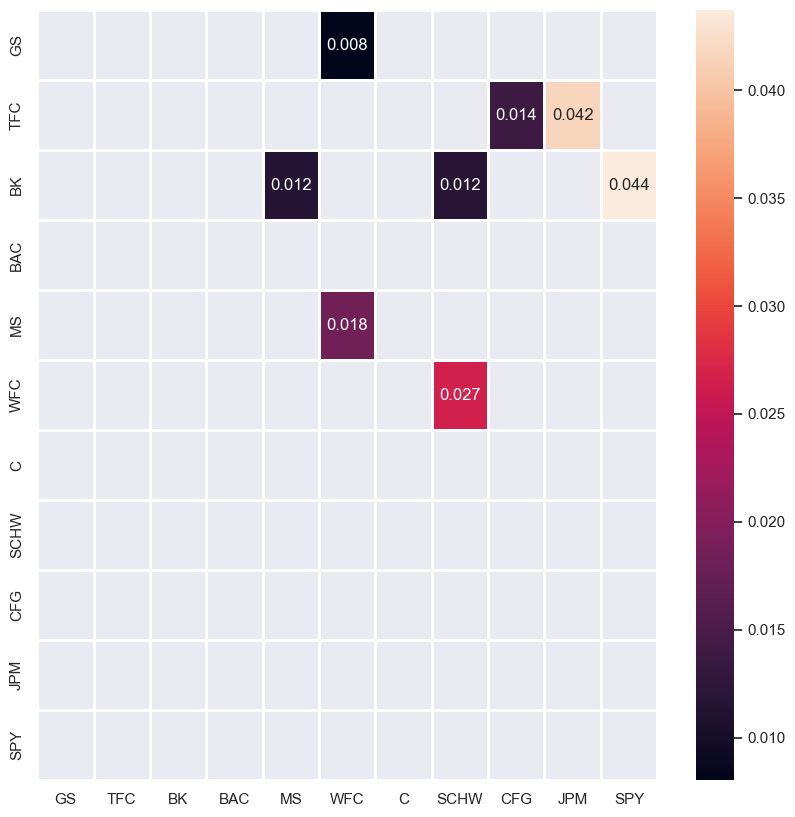

In [21]:
pvalues, pairs = find_cointegrated_pairs(all_df)
plt.figure(figsize=(10,10))
sb.heatmap(pvalues, mask = (pvalues >= 0.05),
           xticklabels=all_df.columns, yticklabels=all_df.columns,
           linewidths = 1, annot = True);

We include `SPY` in the data as benchmark as the market drives the movement of so many securities that we often times may find two seemingly cointegrated securities whereas in reality they are not cointegrated with each other but are just both cointegrated with the market.

There does not appear to be any confounding bias in our selection stocks since `BK` is the only stock cointegrated with `SPY`.

Now, let's choose our 2 stocks to be `WFC` and `GS` as our cointegrated pairs.

p-value = 0.8906362771169642.
None is likely non-stationary.


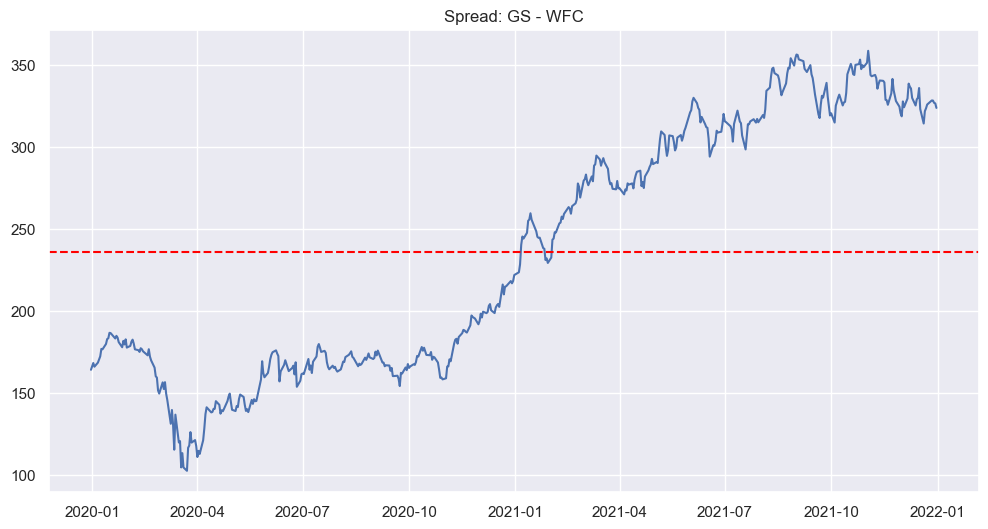

In [22]:
plt.figure(figsize=(12, 6))
WFC = all_df['WFC']
GS = all_df['GS']
spread = GS-WFC
adf(spread, 0.05)

plt.plot(spread)
plt.title('Spread: GS - WFC')
plt.axhline(spread.mean(), color='red', linestyle='--')
plt.show();

Though `GS` and `WFC` are cointegrated, combining them in a naive way does not produce a stationary time series. Thus we have to find the coefficients of the stationary linear combination. We can do so using a standard ordinary least squares regression or a the Johansen Test to find the cointegrating vector.

### 2. Finding the linear combination of cointegrated time series

p-value = 0.0015601250755397395.
None is likely stationary.


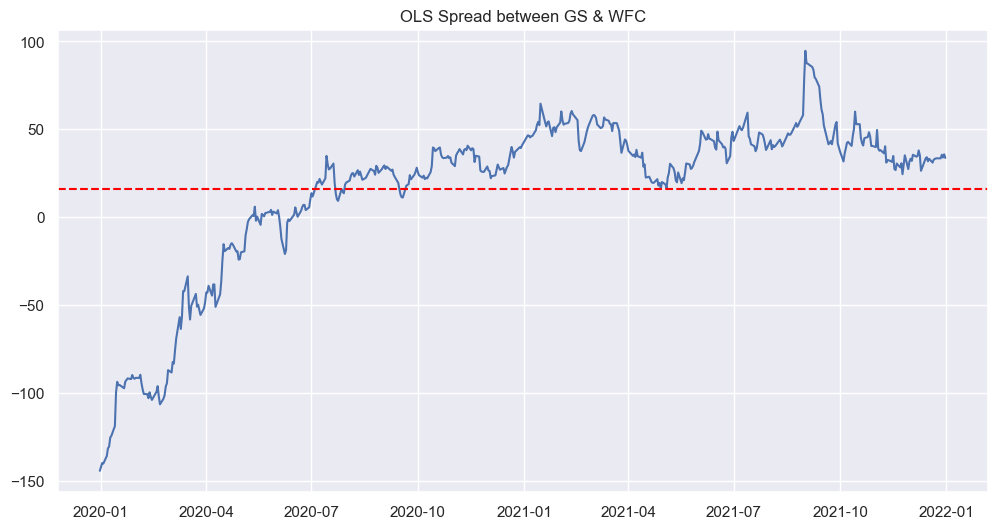

In [23]:
WFC = sm.add_constant(WFC)
results = sm.OLS(GS, WFC).fit()
beta = results.params['WFC']
S1 = WFC['WFC']
S2 = GS
ols_spread = S2 - beta * S1
adf(ols_spread, 0.05)

plt.figure(figsize=(12, 6))
plt.plot(ols_spread)
plt.title('OLS Spread between GS & WFC')
plt.axhline(ols_spread.mean(), color='red', linestyle='--')
plt.show();

We can estimate the linear combination of the 2 cointegrated pairs, `GS` and `WFC` from regression is as follows:

$$ y_{1t} = \beta y_{2t} + c + u_t$$ 

where the residuals, $u_t$ are estimated as $$ u_t = y_{1t} - \beta y_{2t} - c $$ 

We checked that $u_t$ which are the residuals are stationary with our ADF unit root test and realize it is stationary, thereby confirming that we have found the cointegrating vector and linear combination

p-value = 0.0007507261589861033.
None is likely stationary.


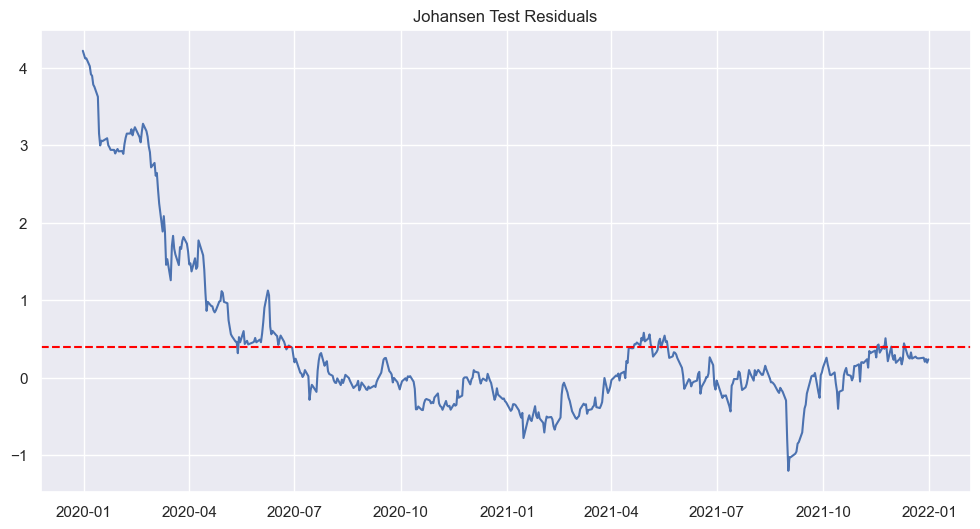

In [24]:
result_j = statsmodels.tsa.vector_ar.vecm.coint_johansen(np.array([S1, S2]).T, det_order=0, k_ar_diff=1)
coint_vector = result_j.evec[:, 0]
lc = S1 * coint_vector[0] + S2 * coint_vector[1]
adf(lc)

plt.figure(figsize=(12, 6))
plt.plot(lc)
plt.title('Johansen Test Residuals')
plt.axhline(lc.mean(), color='red', linestyle='--')
plt.show();

We can see that the Johansen Test produced an identical time series that is also stationary as compared to the ordinary least squares regression. This time, the time series is merely flipped vertically.

### 3. Trading Setup

We will use the spread obtrained from the ordinary least squares regression to trade

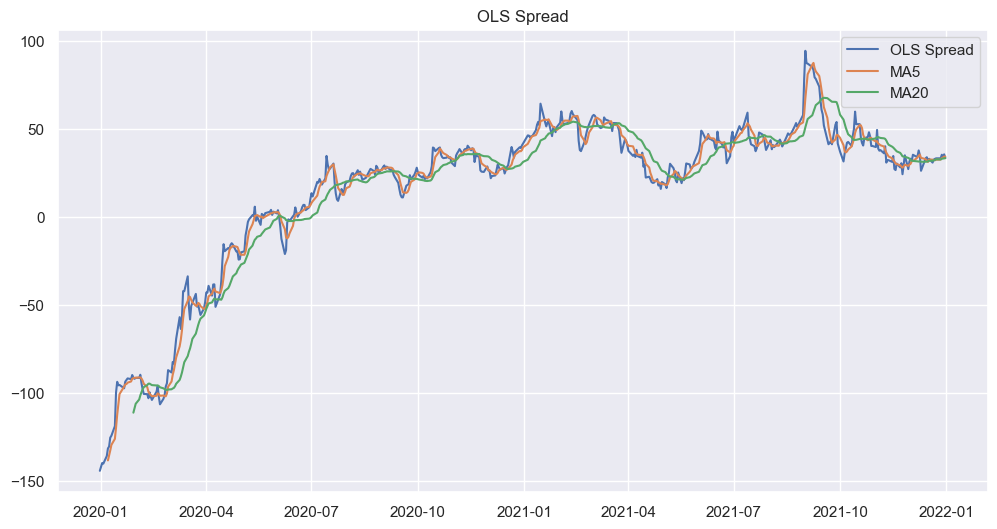

In [25]:
mavg5 = ols_spread.rolling(window=5).mean()
mavg20 = ols_spread.rolling(window=20).mean()

plt.figure(figsize=(12,6))
plt.plot(ols_spread, label='OLS Spread')
plt.plot(mavg5, label='MA5')
plt.plot(mavg20, label='MA20')
plt.title('OLS Spread')
plt.legend()
plt.show();

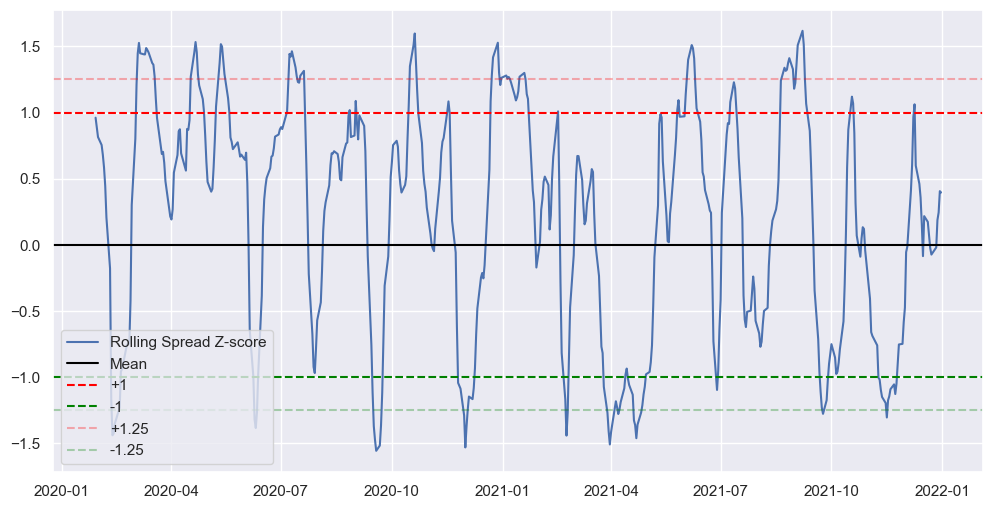

In [26]:
std_ols_spread = ols_spread.rolling(window=20).std()
zscore_ols_spread = (mavg5-mavg20)/std_ols_spread

plt.figure(figsize=(12,6))
plt.plot(zscore_ols_spread)
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(1.25, color='red', alpha=0.3, linestyle='--')
plt.axhline(-1.25, color='green', alpha=0.3, linestyle='--')
plt.legend(['Rolling Spread Z-score', 'Mean', '+1','-1','+1.25', '-1.25'])
plt.show();

We will use the rolling spread z-score to disern when to enter and exit trades. We will be trading the ols spread.

Our trading signal will depend on the above rolling z-score, computed using the 5 and 20 day moving averages of the initial ols spread. The idea is to short the ols spread when the 5d MA > 20d MA and long when the 5d MA < 20d MA. When we short/long depends on backtesting different z-score thresholds we set. 

### 4. Backtesting

$$ S = Y - \beta x $$

where $S$ = `ols_spread`, $Y$ = GS, $\beta$ = beta calculated from ols AND $x$ = WFC. 

In [29]:
def backtest(S1, S2, ols_spread, short_ma, long_ma, zscore_l=-1, zscore_h=1, zscore_m=0.5, leverage=1):
    mavg_short = ols_spread.rolling(window=short_ma).mean()
    mavg_long = ols_spread.rolling(window=long_ma).mean()
    std_long = ols_spread.rolling(window=long_ma).std()
    
    zscore_ols_spread = (mavg_short - mavg_long)/std_long
    
    pnl = np.full_like(ols_spread, np.nan)
    s1_pos = 0
    s2_pos = 0
    s1_value = 0
    s2_value = 0
    
    for i in range(len(ols_spread)):
        s1_iipos = 0 # delta pos
        s2_iipos = 0
        iipnl = 0
        
        print(i, 'zscore: ', zscore_ols_spread[i])
        
        # determining positions for s1 and s2 today
        # long the spread if zscore < -1 : long 1 * s2 and short beta * s1
        if zscore_ols_spread[i] < zscore_l:
            s2_iipos += 1 * leverage
            s1_iipos -= beta * leverage

        # short the spread if zscore > 1 : short 1 * s2 and buy beta * s1
        if zscore_ols_spread[i] > zscore_h:
            s2_iipos -= 1 * leverage
            s1_iipos += beta * leverage

        # close positions if z-score is in between 0.5 and -.5
        if abs(zscore_ols_spread[i]) < zscore_m:
            s1_iipos = -s1_pos
            s2_iipos = -s2_pos

            
        print('s1, s2 pos: ', s1_pos, s2_pos)
        print('today s1, s2 pos delta: ', s1_iipos, s2_iipos)
        
        # check what transactions need to be made

        # for S1
        # if we have no positions in s1
        if s1_pos == 0 and s1_value == 0:
            s1_pos = s1_iipos
            s1_value -= s1_iipos * S1[i] # flip the sign bc if we're short we'll have pos value and vice versa
        # if net short position in s1
        elif s1_pos < 0 and s1_value > 0:
            # closing shorts and adding longs
            if s1_iipos > 0:
                iipnl += (s1_value + s1_pos * S1[i]) # pnl is the diff between our positive short value and the money we expend to buy back stocks
                s1_pos = s1_iipos # update s1_pos
                s1_value = -(s1_iipos * S1[i]) # update s1_value 
            # adding shorts
            if s1_iipos < 0:
                s1_pos += s1_iipos # add to s1_pos since s1_iipos is neg
                s1_value -= s1_iipos * S1[i] # add to s1_value since s1_iipos is neg
        # if net long position in s1     
        elif s1_pos > 0 and s1_value < 0:
            # closing longs and adding shorts
            if s1_iipos < 0:
                iipnl += (s1_value + s1_pos*S1[i]) # pnl is the diff between profit from sale and value 
                s1_pos = s1_iipos # update s1_pos
                s1_value = -(s1_iipos * S1[i]) # update s1_value 
            # adding longs
            if s1_iipos > 0:
                s1_pos += s1_iipos
                s1_value -= s1_iipos * S1[i]

        # for S2
        # if we have no positions in s2
        if s2_pos == 0 and s2_value == 0:
            s2_pos = s2_iipos
            s2_value -= s2_iipos * S2[i] # flip the sign bc if we're short we'll have pos value and vice versa
        # if net short position in s2
        elif s2_pos < 0 and s2_value > 0:
            # closing shorts and adding longs
            if s2_iipos > 0:
                iipnl += (s2_value - s2_pos * S2[i]) # pnl is the diff between our positive short value and the money we expend to buy back stocks
                s2_pos = s2_iipos # update s2_pos
                s2_value = -(s2_iipos * S2[i]) # update s2_value 
            # adding shorts
            if s2_iipos < 0:
                s2_pos += s2_iipos # add to s2_pos since s2_iipos is neg
                s2_value -= s2_iipos * S2[i] # add to s2_value since s2_iipos is neg
        # if net long position in s2     
        elif s2_pos > 0 and s2_value < 0:
            # closing longs and adding shorts
            if s2_iipos < 0:
                iipnl += (s2_value + s2_pos * S2[i]) # pnl is the diff between profit from sale and value 
                s2_pos = s2_iipos # update s2_pos
                s2_value = -(s2_iipos * S2[i]) # update s2_value 
            # adding longs
            if s2_iipos > 0:
                s2_pos += s2_iipos
                s2_value -= s2_iipos * S2[i]

        pnl[i] = iipnl
        print('value: ', s1_value, s2_value)
        print('todays pnl: ', iipnl)
        print()
        
    return pnl

In [30]:
pnl = backtest(S1, S2, ols_spread, 5, 20)

0 zscore:  nan
s1, s2 pos:  0 0
today s1, s2 pos delta:  0 0
value:  0.0 0.0
todays pnl:  0

1 zscore:  nan
s1, s2 pos:  0 0
today s1, s2 pos delta:  0 0
value:  0.0 0.0
todays pnl:  0

2 zscore:  nan
s1, s2 pos:  0 0
today s1, s2 pos delta:  0 0
value:  0.0 0.0
todays pnl:  0

3 zscore:  nan
s1, s2 pos:  0 0
today s1, s2 pos delta:  0 0
value:  0.0 0.0
todays pnl:  0

4 zscore:  nan
s1, s2 pos:  0 0
today s1, s2 pos delta:  0 0
value:  0.0 0.0
todays pnl:  0

5 zscore:  nan
s1, s2 pos:  0 0
today s1, s2 pos delta:  0 0
value:  0.0 0.0
todays pnl:  0

6 zscore:  nan
s1, s2 pos:  0 0
today s1, s2 pos delta:  0 0
value:  0.0 0.0
todays pnl:  0

7 zscore:  nan
s1, s2 pos:  0 0
today s1, s2 pos delta:  0 0
value:  0.0 0.0
todays pnl:  0

8 zscore:  nan
s1, s2 pos:  0 0
today s1, s2 pos delta:  0 0
value:  0.0 0.0
todays pnl:  0

9 zscore:  nan
s1, s2 pos:  0 0
today s1, s2 pos delta:  0 0
value:  0.0 0.0
todays pnl:  0

10 zscore:  nan
s1, s2 pos:  0 0
today s1, s2 pos delta:  0 0
value:  

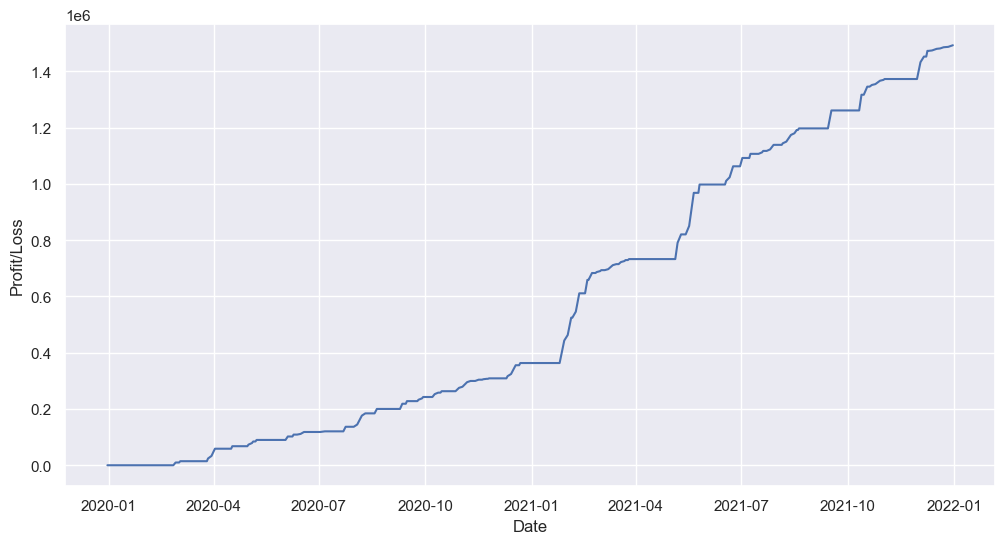

Total pnl:  1492481.941487091


In [31]:
plt.figure(figsize=(12,6))
plt.plot(all_df.index, pnl.cumsum(), label='Cumulative pnl')
plt.ylabel('Profit/Loss')
plt.xlabel('Date')
plt.show();
print('Total pnl: ', pnl.cumsum()[-1])

### Next steps

Explore more sophisticated statistics such as: 
   * Hurst exponent
   * Half-life of mean reversion inferred from an Ornstein–Uhlenbeck process
   * Kalman filters